## DDP dataset

#### Import Packages

In [2]:
import mne
import pandas as pd
import numpy as np
import os

import PATH

from functions import ddp

labels_filename = "DDP_labels.xlsx"

#### Create age labels for DDP dataset


In [2]:
ddp.create_labels(PATH.DDP, labels_filename)

#### Analyse single raw file
+ All the DDP files have differently set-up events. 
+ Loading with 'mne.io.read_raw_cnt' produces two RuntimeWarnings (can be ignored)
+ Not all files are able to load for multiple reasons (e.g. 437, 2147)

Reading 0 ... 1196739  =      0.000 ...  2393.478 secs...


/tmp/ipykernel_210044/1549994689.py:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(metadata["path"][raw_index], preload = True)
/tmp/ipykernel_210044/1549994689.py:4: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = mne.io.read_raw_cnt(metadata["path"][raw_index], preload = True)


Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']


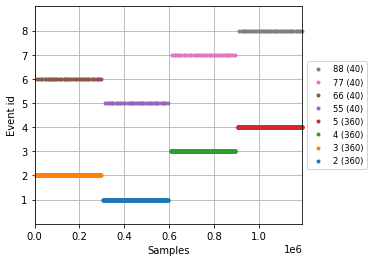

Using matplotlib as 2D backend.
Opening raw-browser...


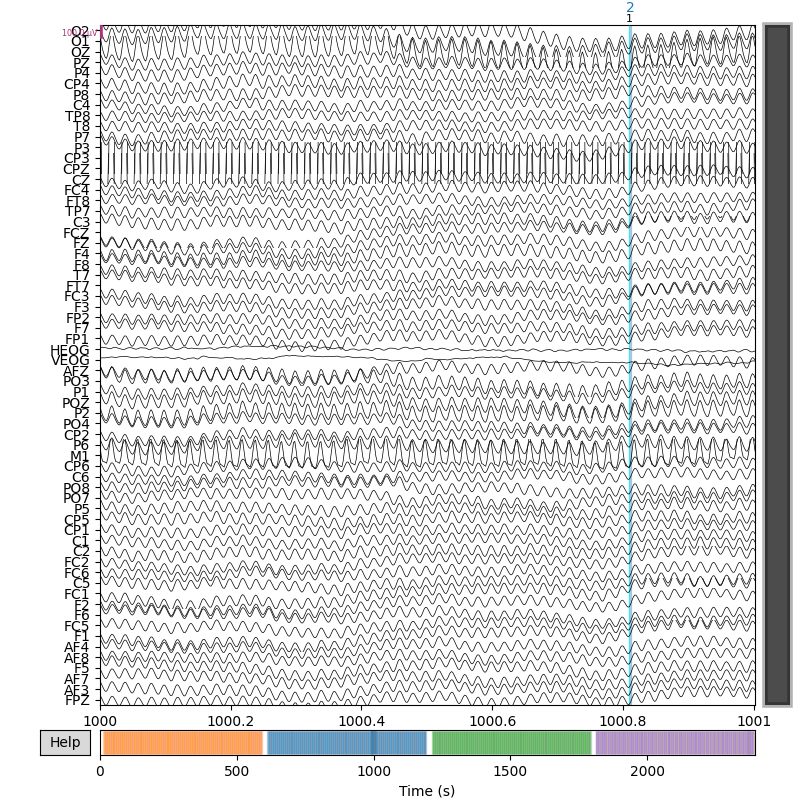

In [4]:
raw_index = 50 # index from 0 to 2147 cnt files

labels = pd.read_excel(os.path.join(PATH.DDP, labels_filename)) 
raw = mne.io.read_raw_cnt(metadata["path"][raw_index], preload = True)
events, event_dict = mne.events_from_annotations(raw)
fig = mne.viz.plot_events(events, event_id = event_dict)

%matplotlib widget
fig = mne.viz.plot_raw(raw, events, n_channels=70, scalings = 50e-6  ,duration = 1, start = 1000)

#### Process DDP

In [23]:
labels = pd.read_excel(os.path.join(PATH.DDP, labels_filename)) 

for i, file in labels.iterrows():
    print(f"Checking out file: {file['file']}")
        
    filename_processed_raw = os.path.join(PATH.DDP_processed, file['file'] + ".npy")
    
    if os.path.exists(filename_processed_raw):
        print(f"File {filename_processed_raw} already exists.")
        continue
    
    
    # Step 2: Import data and labels 
    signal_collect, label_collect, ch_names = ddp.read_cnt_file(file['path'],
                                                            file['age_days'],
                                                            event_idx = [2, 3, 4, 5, 12, 13, 14, 15],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)    
    
    if signal_collect is None:
        continue
        
    # Step 3: standardize data
    signal_collect = ddp.standardize_EEG(signal_collect, std_aim = 1, centering = 'per_channel', scaling = 'global')

    # Step 4: Save raw data
    if signal_collect is not None:
        np.save(filename_processed_raw, signal_collect)
    

Checking out file: 001_11_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk.cnt


/home/fpauwels/eegyolk/floris_files/functions/ddp.py:109: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)
/home/fpauwels/eegyolk/floris_files/functions/ddp.py:109: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['2', '3', '4', '5', '55', '66', '77', '88']
Found 247 bad epochs in a total of 30  channels.
Found bad channel (more than 72.0  bad epochs): Channel no:  9
Found bad channel (more than 72.0  bad epochs): Channel no:  4
Marked 129 bad epochs in a total of 360  epochs.
Interpolating bad channels
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 28 sensor positions
In

KeyboardInterrupt: 

#### Analyse processed data

In [3]:
PATH.DDP_processed

'/volume-ceph/processed/DDP'

#### Create and Load metadata file of processed data

In [9]:
import mne
import pandas as pd
import numpy as np
import os

import PATH

from functions import ddp

labels_filename = "DDP_labels.xlsx"
labels = pd.read_excel(os.path.join(PATH.DDP, labels_filename)) 

path_labels_processed = os.path.join(PATH.processed, 'DDP_labels_processed.xlsx')

if(os.path.exists(path_labels_processed)):
    labels_processed = pd.read_excel(path_labels_processed)
else:
    labels_processed = ddp.create_labels_processed(PATH.DDP_processed, path_labels_processed, labels)

#### Predict age from processed data (DL)

In [10]:
from sklearn.model_selection import train_test_split

labels_processed = pd.read_excel(path_labels_processed)
subject_ids = sorted(list(set(labels_processed["code"].tolist())))
IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

In [11]:
subject_ids = sorted(list(set(labels_processed["code"].tolist())))
print(f"{len(subject_ids)} unique subject id's")

304 unique subject id's


In [12]:
from functions  import dataset_generator as dg

train_generator_noise = dg.DataGenerator(list_IDs = IDs_train,
                                      BASE_PATH = PATH.DDP_processed,
                                      metadata = labels_processed,
                                      n_average = 30,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

val_generator = dg.DataGenerator(list_IDs = IDs_val,
                              BASE_PATH = PATH.DDP_processed,
                              metadata = labels_processed,
                              n_average = 30,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)

In [13]:
# train_generator_noise.__getitem__(0)

#### DL Training 

In [14]:
from functions import deep_learning as dl
from models.DNN import fully_connected_model
import PATH

import os
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

model = fully_connected_model()

optimizer = Adadelta(learning_rate=0.01)    
              
model.compile(loss='mean_squared_error', 
              optimizer=optimizer, 
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# 01 seems to be incorrect (makes too many predictions, changed model)
# Fully_connected_regressor_01: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
# Fully_connected_regressor_02: MSE, Adadelta, N_average=30, 5000 epochs, ES=1000, RLR=200, gaussian=0.01
output_filename = 'Fully_connected_regressor_FINAL_LOCAL'
output_file = os.path.join(PATH.models, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=1200, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=0.0001, verbose=1)



epochs = 5000

# fit network
history = model.fit(x=train_generator_noise,
                    validation_data=val_generator,
                    epochs=epochs, 
                    callbacks=[checkpointer, earlystopper, reduce_lr])

/volume-ceph/processed/DDP/126_41_mr_mmn36_mixed.cnt.npy
/volume-ceph/processed/DDP/137_11_mr_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp.cnt.npy
/volume-ceph/processed/DDP/181_41_jr_mmn39_380.cnt.npy
/volume-ceph/processed/DDP/735-125-41m-mr-mmn39.cnt.npy
/volume-ceph/processed/DDP/033_17_mc_mmn25sl.cnt.npy
/volume-ceph/processed/DDP/438_35_jd_mmn25_wk.cnt.npy
/volume-ceph/processed/DDP/433_23_jd_mmn25_wk.cnt.npy
/volume-ceph/processed/DDP/165_11_jr_mmn58_wk.cnt.npy
/volume-ceph/processed/DDP/488_35_jd_mmn25_wk.cnt.npy
/volume-ceph/processed/DDP/701-008-41m-jr-mmn25.cnt.npy
Epoch 1/5000
/volume-ceph/processed/DDP/320_23_jc_mmn36_wk.cnt.npy
/volume-ceph/processed/DDP/011_35_jc_mmn36.cnt.npy
/volume-ceph/processed/DDP/632-399-11m-jc-mmn25-waak.cnt.npy
/volume-ceph/processed/DDP/163_23_jr_mmn36_wk.cnt.npy
/volume-ceph/processed/DDP/617-289-23m-mc-mmn25-slp.cnt.npy
/volume-ceph/processed/DDP/165_35_jr_mmn36_wk.cnt.npy
/volume-ceph/processed/DDP/123_11_jr_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk.cn

/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fpauwels/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


/volume-ceph/processed/DDP/469_23_md_mmn36_wk.cnt.npy
/volume-ceph/processed/DDP/348_11_jc_mmn25_2_wk.cnt.npy
/volume-ceph/processed/DDP/170_11_mr_mmn47_slp.cnt.npy
/volume-ceph/processed/DDP/115_29_mr_mmn36_slp.cnt.npy
/volume-ceph/processed/DDP/325_11_mc_mmn58_slp.cnt.npy
/volume-ceph/processed/DDP/152_11_jr_mmn.cnt.npy
 34/144 [======>.......................] - ETA: 16:37 - loss: nan - root_mean_squared_error: nan - mean_absolute_error: nan                  /volume-ceph/processed/DDP/137_41_mr_mmn39_380_wk.cnt.npy
/volume-ceph/processed/DDP/344_11_jc_mmn25_2_mixed.cnt.npy
/volume-ceph/processed/DDP/342_11_jc_mmn58_mixed.cnt.npy
/volume-ceph/processed/DDP/182_11_jr_mmn25_slp.cnt.npy
/volume-ceph/processed/DDP/307_17_jc_mmn36_wakker.cnt.npy
/volume-ceph/processed/DDP/162_11_mr_mmn36.cnt.npy
/volume-ceph/processed/DDP/102_23_jr_mmn36_wk_mmn25_wk.cnt.npy
/volume-ceph/processed/DDP/486_11_jd_mmn47_wk.cnt.npy
/volume-ceph/processed/DDP/343_23_mc_mmn36_wk.cnt.npy
/volume-ceph/processed/DDP

KeyboardInterrupt: 

/volume-ceph/processed/DDP/170_17_mr_mmn_36_wk.cnt.npy
/volume-ceph/processed/DDP/624-373-23m-mc-mmn36.cnt.npy
/volume-ceph/processed/DDP/317_11_mc_mmn_2.cnt.npy
/volume-ceph/processed/DDP/494_41_jd_mmn39_wk.cnt.npy
/volume-ceph/processed/DDP/494_41_jd_mmn39_wk.cnt.npy
/volume-ceph/processed/DDP/133_23_jr_mmn25_wk.cnt.npy
/volume-ceph/processed/DDP/637-479-23m-mc-mmn36.cnt.npy
/volume-ceph/processed/DDP/165_11_jr_mmn36.cnt.npy
